# Seattle AirBnB Superhosts


## Business Understanding
AirBnB is an online platform that helps people looking for accomodation to connect with suitable properties that hosts want to rent out. This business model relies heavily on both guests and hosts to provide each other with a positive experience that encourages them to continue using AirBnB and to recommend it to others. 

The best hosts are rewarded with "Superhost" status reflecting their experience and high rankings, and can display a badge on their listings so that customers are able to identify top-quality listings that meet their needs. But what does this status actually mean in practice? In this analysis I will follow the CRISP-DM process to address 3 questions of interest:
1. Does being a superhost lead to an increase in booking rate or listing price?
2. Are the amenities provided by superhosts different to those provided by non-superhosts?
3. Can we predict which listings belong to superhosts based on AirBnB listings data?


## Data Understanding
To answer these questions, I will use the Seattle AirBnB listings dataset. This contains descriptions for each listing and a lot of information about the host, availability, amenities, ratings and price.

Some of the most useful columns are:
**host_is_superhost:** t/f flag to identify whether the host is a superhost  
**availability_30:** Number of days the listing is available for in the next 30 days (also 60 and 90 days)  
**price:** Daily price in $  
**amenities:** Multi-value set of all amenities provided e.g. {"Cable TV","Elevator in Building",Heating,Washer,Dryer}  

Before conducting any analysis or modelling, there will be some data wrangling required to clean and prepare the data, such as dealing with missing values and encoding categorical factors appropriately.


## Data Preparation

In [1]:
#Import python packages that will be used to perform analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
#Load listings data
listings_df = pd.read_csv('./data/listings.csv')
print('Listings dataset contains {} rows and {} columns'.format(listings_df.shape[0],listings_df.shape[1]))

Listings dataset contains 3818 rows and 92 columns


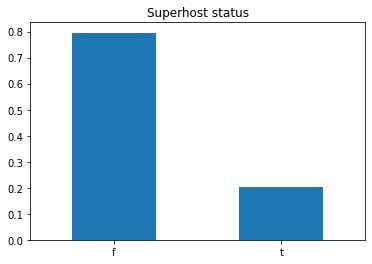

In [3]:
#Check the distribution of the superhost column - can see only 20% of listings are from superhosts
superhost_vals = listings_df['host_is_superhost'].value_counts()

(superhost_vals/listings_df.shape[0]).plot(kind="bar");
plt.title("Superhost status") ;
plt.xticks(rotation = 0) ;


A large proportion of the columns will not be relevant to the questions of interest. To make the dataset more manageable, we'll take a subset of the most useful columns. I'll also remove redundant columns which only contain one distinct value (e.g. city), columns with large amounts of free text (e.g. description) and url / ID columns that offer no useful information.

In [4]:
columns_to_drop = ['id','listing_url','scrape_id','last_scraped','name','summary','space','description',
                   'experiences_offered','neighborhood_overview','notes','transit','thumbnail_url','medium_url',
                   'picture_url','xl_picture_url','host_id','host_since','host_url','host_name','host_about','host_thumbnail_url',
                   'host_picture_url','host_neighbourhood','host_location','host_verifications','street','neighbourhood',
                   'neighbourhood_cleansed','city','state','zipcode','market','smart_location',
                   'country_code','country','latitude','longitude','calendar_last_scraped','first_review','last_review',
                   'requires_license','license','jurisdiction_names','weekly_price','monthly_price','extra_people']


print('Dropping {} columns'.format(len(columns_to_drop)))

listings_df.drop(columns_to_drop,axis=1,inplace=True)

#Confirm new size of dataset
print('Listings dataset now contains {} rows and {} columns'.format(listings_df.shape[0],listings_df.shape[1]))

Dropping 47 columns
Listings dataset now contains 3818 rows and 45 columns


In [5]:
listings_df.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,within a few hours,96%,100%,f,3.0,3.0,t,t,Queen Anne,t,...,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,within an hour,98%,100%,t,6.0,6.0,t,t,Queen Anne,t,...,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,within a few hours,67%,100%,f,2.0,2.0,t,t,Queen Anne,t,...,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15
3,NaN,NaN,NaN,f,1.0,1.0,t,t,Queen Anne,t,...,NaN,NaN,NaN,NaN,f,flexible,f,f,1,NaN
4,within an hour,100%,NaN,f,2.0,2.0,t,t,Queen Anne,t,...,10.0,10.0,9.0,9.0,f,strict,f,f,1,0.89


In [6]:
#Convert price columns to integer values - remove $sign
def str_price_to_integer(price_str):
    price_str = price_str.str.replace('$','',regex=False)
    price_str = price_str.str.replace(',','',regex=False)
    return price_str.astype(float)

price_columns = ['price','security_deposit','cleaning_fee']
for col in price_columns:
    try:
        listings_df[col] = listings_df[[col]].apply(str_price_to_integer,axis=0)
    except:
        print('Already converted price to numeric column')


### Missing values
First I will identify and remove any rows with missing data for the host_is_superhost column. We would normally prefer not to discard records, but these will be no use for understanding the differences between superhosts and non-superhosts.  
Then I will check for other missing values within the data and impute values as required.

In [7]:
print('Rows with missing superhost flag: {}'.format(listings_df['host_is_superhost'].isna().sum()))
print('Deleting these rows')

listings_df = listings_df.dropna(subset=['host_is_superhost'],axis=0)

Rows with missing superhost flag: 2
Deleting these rows


In [8]:
#Identify any other columns with missing values and the proportion that are missing
missing_cols = listings_df.isna().sum() / len(listings_df)
missing_cols = missing_cols[missing_cols > 0].sort_values(ascending=False)
missing_cols

square_feet                    0.974581
security_deposit               0.511006
cleaning_fee                   0.269654
host_acceptance_rate           0.202044
review_scores_accuracy         0.171908
review_scores_checkin          0.171908
review_scores_value            0.171384
review_scores_location         0.171122
review_scores_cleanliness      0.170597
review_scores_communication    0.170073
review_scores_rating           0.169025
reviews_per_month              0.163784
host_response_rate             0.136530
host_response_time             0.136530
bathrooms                      0.004193
bedrooms                       0.001572
beds                           0.000262
property_type                  0.000262
dtype: float64

From this, we can see that there are several columns with missing values, but there are likely to be a variety of reasons for these. For example, the review scores are likely to be missing because the listing is new and hasn't been reviewed yet, whereas a missing cleaning fee probably means no fee is charged. The square_feet column is 97% missing, so would consider this to be worth dropping from further analysis.

In [9]:
#Drop the square feet column as it has too many missing values to be worth imputing
listings_df.drop('square_feet',axis=1,inplace=True)

#For columns where missing probably means 0, impute this value
missing_means_0_cols = ['security_deposit','cleaning_fee']

for col in missing_means_0_cols:
    listings_df[col] = listings_df[col].fillna(0)


In [10]:
#For other columns impute the mode if it is categorical, or the median if it's numeric
cols_to_impute_mode = ['host_acceptance_rate', 'host_response_rate', 'host_response_time',  'property_type']

cols_to_impute_median = ['review_scores_accuracy', 'review_scores_checkin', 'review_scores_value', 
                         'review_scores_location', 'review_scores_cleanliness', 'review_scores_communication', 
                         'review_scores_rating', 'reviews_per_month', 'bathrooms', 'bedrooms', 'beds']

    
impute_mode = lambda col: col.fillna(col.mode()[0])
impute_median = lambda col : col.fillna(col.median())

for col in cols_to_impute_mode:
    listings_df[col] = listings_df[[col]].apply(impute_mode,axis=0)

for col in cols_to_impute_median:
    listings_df[col] = listings_df[[col]].apply(impute_mode,axis=0)

In [11]:
#Repeat missing value check to confirm there are none left...
#Identify any other columns with missing values and the proportion that are missing
missing_cols = listings_df.isna().sum() / len(listings_df)
missing_cols = missing_cols[missing_cols > 0].sort_values(ascending=False)
missing_cols

Series([], dtype: float64)

### Categorical factors

Reformat price columns that are currently being treated as strings so that these can be handled as numerics.  
Use dummy encoding to prepare categorical factors for modelling.
    

In [12]:
#Identify remaining categorical factors for dummy encoding
categorical_vars = list(listings_df.select_dtypes('object').columns)
#Remove columns from this list that aren't appropriate for dummy encoding but may be useful later
categorical_vars.remove('calendar_updated')
categorical_vars.remove('host_is_superhost')
categorical_vars.remove('amenities')
    
listings_df = pd.get_dummies(listings_df, columns=categorical_vars, drop_first = True)
listings_df   

,host_is_superhost,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,amenities,price,security_deposit,...,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_t,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_t,require_guest_phone_verification_t
0,f,3.0,3.0,4,1.0,1.0,1.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,...,0,0,0,0,1,0,1,0,0,0
1,t,6.0,6.0,4,1.0,1.0,1.0,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,...,0,0,0,0,1,0,0,1,1,1
2,f,2.0,2.0,11,4.5,5.0,7.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,1000.0,...,0,0,0,0,1,0,0,1,0,0
3,f,1.0,1.0,3,1.0,0.0,2.0,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",100.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,f,2.0,2.0,6,2.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,700.0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,f,354.0,354.0,6,2.0,3.0,3.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",359.0,0.0,...,0,0,0,0,1,0,0,1,0,0
3814,f,1.0,1.0,4,1.0,1.0,2.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",79.0,500.0,...,0,0,0,0,1,0,1,0,0,0
3815,f,1.0,1.0,2,1.0,1.0,1.0,"{""Cable TV"",""Wireless Internet"",Kitchen,""Free ...",93.0,250.0,...,0,0,0,0,1,0,1,0,0,0
3816,f,1.0,1.0,2,1.0,0.0,1.0,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",99.0,300.0,...,0,0,0,0,1,0,1,0,0,0


## 1. Does being a superhost lead to an increase in booking rate or listing price?
For this analysis we will only select listings where the calendar has been updated within the last 3 months - this should reduce the effect of listings that are not currently available to be booked

In [13]:
calendar_filter_list = ['today', 'yesterday', '2 days ago', '3 days ago', '4 days ago', '5 days ago', '6 days ago',
                        'a week ago','1 week ago', '2 weeks ago', '3 weeks ago', '4 weeks ago', '5 weeks ago'
                        '6 weeks ago', '7 weeks ago', '2 months ago']

df_recently_updated = listings_df[listings_df['calendar_updated'].isin(calendar_filter_list)]
df_recently_updated = listings_df[['host_is_superhost','availability_30','availability_90','availability_365','price']]


In [14]:
#Compare the average availability for the next 365 days
print(df_recently_updated.groupby('host_is_superhost').mean().transpose())

host_is_superhost           f           t
availability_30     16.703752   17.109254
availability_90     57.356155   60.949871
availability_365   245.831468  241.149100
price              127.391376  130.140103


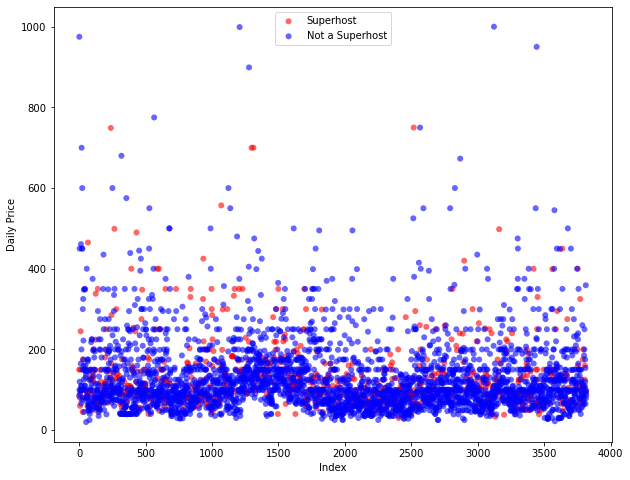

In [15]:
fig, ax = plt.subplots(figsize=(10,8));

for i in ['t','f']:
    if i == 't':
        color = 'red'
        label = 'Superhost'
    else:
        color = 'blue'
        label = 'Not a Superhost'
    ax.scatter(x = listings_df[listings_df.host_is_superhost == i].index, 
               y = listings_df[listings_df.host_is_superhost == i]['price'],
               c=color, label=label, alpha=0.6, edgecolors='none');
plt.ylabel('Daily Price');
plt.xlabel('Index');

ax.legend();
#ax.grid(True);

plt.show();

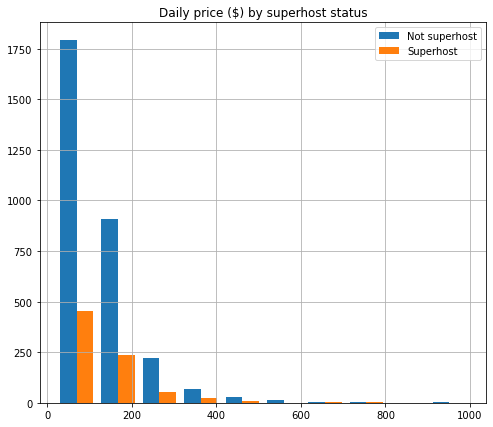

In [16]:
#Plot histogram of daily price
n_bins = 10
superhost_label = ['Not superhost','Superhost']
hist_df = listings_df.reset_index().pivot('index','host_is_superhost','price')
plt.figure(figsize=(8,7))
plt.grid(True)
plt.hist(hist_df, n_bins, histtype='bar',label=superhost_label)
plt.legend()

plt.title('Daily price ($) by superhost status')

plt.show()

This analysis hasn't shown much benefit to booking rates or daily price for being a superhost. Superhost listings actually have a higher average availability in the next 30 and 90 days, although they possibly do benefit from more advance bookings, having a lower number of days available on average over the next full year.  

There is some evidence that being a superhost enables hosts to charge a higher daily price - the average price per night is $130 for superhosts compared to non-superhosts, and the graph above shows a lower proportion of superhosts falling into the lowest price bucket. However, there are a lot of other variables that could be causing this, such as location and number of bedrooms.

## 2. Are the amenities provided by superhosts different to those provided by non-superhosts?

The data contains a column that identifies the amenities available at each listing. This is in the form of a set of values e.g. {"Cable TV","Elevator in Building",Heating,Washer,Dryer}. The first task will be to split this out into individual columns for each amenity with a True value if that amenity is mentioned, or a False if not. Then we can compare these between superhosts and non-superhosts.

In [17]:
#Create list of all possible amenities
#Create list of all possible amenities
amenities_list = ['TV','Cable TV','Internet','Wireless Internet','Kitchen','Free Parking on Premises','Pets Allowed',
                  'Pets live on this property','Other pet(s)','Heating','Washer','Dryer','Smoke Detector',
                  'Carbon Monoxide Detector','Fire Extinguisher','Essentials','Shampoo','Hangers','Air Conditioning',
                  'Family/Kid Friendly','Buzzer/Wireless Intercom','First Aid Kit','Safety Card','Dog(s)','Cat(s)',
                  'Hot Tub','Indoor Fireplace','Breakfast','Elevator in Building','Suitable for Events',
                  '24-Hour Check-in','Hair Dryer','Iron','Laptop Friendly Workspace','Wheelchair Accessible',
                  'Gym','Lock on Bedroom Door','Pool','Smoking Allowed','Doorman']

len(amenities_list)

40

In [18]:
#Create a copy of the dataframe with just the necessary columns
amenities_df = listings_df[['host_is_superhost','amenities']].copy()

def check_for_amenity(amenities_str,amenity_value):
    '''returns true if amenity_value is present in amenities_str'''
    
    #Clean string by removing unnecessary punctuation
    amenities_str = amenities_str.replace('{','')
    amenities_str = amenities_str.replace('}','')
    amenities_str = amenities_str.replace('"','')
    
    return amenity_value in amenities_str.split(',')
    

for i in amenities_list:
    amenities_df[i] = amenities_df.apply(lambda x : check_for_amenity(x['amenities'],i),axis=1)

print(amenities_df.head())


#Check for any amenity column that doesn't have at least one True value (i.e. appear once in data)
#Should be none as amenities_list was created from the Seattle data
amenity_check = amenities_df.drop(['host_is_superhost','amenities'],axis=1)
print('Unselected amenities', amenity_check.columns[amenity_check.sum() == 0])

  host_is_superhost                                          amenities     TV  \
0                 f  {TV,"Cable TV",Internet,"Wireless Internet","A...   True   
1                 t  {TV,Internet,"Wireless Internet",Kitchen,"Free...   True   
2                 f  {TV,"Cable TV",Internet,"Wireless Internet","A...   True   
3                 f  {Internet,"Wireless Internet",Kitchen,"Indoor ...  False   
4                 f  {TV,"Cable TV",Internet,"Wireless Internet",Ki...   True   

   Cable TV  Internet  Wireless Internet  Kitchen  Free Parking on Premises  \
0      True      True               True     True                     False   
1     False      True               True     True                      True   
2      True      True               True     True                      True   
3     False      True               True     True                     False   
4      True      True               True     True                     False   

   Pets Allowed  Pets live on this pro

In [19]:
#Calculate % of listings that refer to each amenity - since these are boolean factors, this is the same as the mean
amenities_summary_df = amenities_df.groupby('host_is_superhost').mean().transpose()*100

#Identify differences in the amenities offered
amenities_summary_df['percent_diff_by_superhost_status'] = amenities_summary_df['t'] - amenities_summary_df['f']
amenities_summary_df = amenities_summary_df.sort_values('percent_diff_by_superhost_status',ascending=False)

#Visualise these differences
amenities_summary_df.style.bar(subset=['percent_diff_by_superhost_status'], align='mid', color=['#d65f5f', '#5fba7d'])

host_is_superhost,f,t,percent_diff_by_superhost_status
Shampoo,66.392363,83.804627,17.412264
First Aid Kit,41.013825,55.784062,14.770237
Fire Extinguisher,55.134957,66.838046,11.703089
Carbon Monoxide Detector,62.870309,73.778920,10.908611
Safety Card,16.919026,27.249357,10.330332
Pets live on this property,21.132324,30.976864,9.844540
Smoke Detector,84.265964,92.544987,8.279023
Essentials,83.113891,91.388175,8.274284
Hair Dryer,18.861093,25.706941,6.845848
Dog(s),11.981567,18.637532,6.655965


From the plot above, we can see that there is not a significant difference in the proportion of hosts providing amenities such as TV or internet. The biggest difference seems to be that superhosts are more likely to provide additional basic/safety-focused amenities like shampoo, first aid kits and fire extinguishers. Unfortunately we can't tell whether this is something that guests prefer and rate more highly, or whether this just reflects that superhosts set a higher standard for themselves!

## Modelling - Predicting superhosts

This is a binary classification task with a boolean outcome - is the listing from a superhost or not? For this reason I'll use logistic regression, which is well suited to this task.

In [20]:
#Map host_is_superhost to 0/1 values
superhost_map = {"f" : 0,
                 "t" : 1}

listings_df['superhost'] = listings_df['host_is_superhost'].map(superhost_map)


X = listings_df.drop(columns=['host_is_superhost','superhost','amenities','calendar_updated'],axis=1)
y = listings_df['superhost']

#Scale numeric data
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(X)

#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print('Train set rows: {}'.format(len(X_train)))
print('Test set rows: {}'.format(len(X_test)))

#initialise and fit model
mdl = LogisticRegression(solver='liblinear', max_iter=300)
mdl.fit(X_train, y_train)

#Score data
train_score = mdl.score(X_train, y_train)
test_score = mdl.score(X_test, y_test)
print('Train accuracy = {}, Test accuracy = {}'.format(train_score, test_score))

Train set rows: 2862
Test set rows: 954
Train accuracy = 0.822501747030049, Test accuracy = 0.8186582809224319


## Evaluation
